In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
import glob

In [3]:
import sys
sys.path.append('../src') 

In [4]:
from gi import event_size, fiducial_df, twocluster_df, event_mult, d12, dtz, select_image_from_df 
from cnn_plot import histoplot, plot_amplitude, plot_image, scatter_xyz

# giCsI
- Shows the data selection and reduction.
- The input df are:
    -  "isensor_data", with the counts in phe in each of the SiPMs.
    -  "gamma_interactions" with the locations in which the gamma interacted in the crystal
    -  "global_pars" with data about the run (dimensions, crystal material)
    -  "sensor_positions", with the position of sensors.

- The nb illustrates the flow o the algorithm to prepara the data for the CNN (prepareData.py in this directory).
    - from "isensor_data", one extracts the images to be analyzed.
    - from "gamma_interactions", one extracts the metadata.
 
 - The selection flow is:
    1. Fraction of events interacting in crystal. This is found from the ration between the total number of gammas that were shot (in global_pars) and the size o the "gamma_interaction" df.
    2. Fiducial cuts (events contained in crystal).
    3. Energy cut (events are near the peak).
  
- The list of events that passes the above cuts is used to select events in the "sensor_data" df. Finally, a df2c dataframe is produced, with the metadata (for each interaction we keep two potential clusters, x1,y1,e1, x2,y2,e2, which can be eventually identical).
  

## CsI

## Data directories

In [9]:
g4dir = "/Users/jjgomezcadenas/Data/G4Prods/crystalGI/G4CSIH1"  # for practical reasons CsITl used (50k/MeV rathar than 100 k/MeV)
fid = "isensor_data_csi_10.csv"
fgi = "gamma_interactions_csi_10.csv"
fgp = "global_pars_10.csv"
fsp = "sensor_positions.csv"

## Read out global parameters

In [10]:
dfgp = pd.read_csv(f"{g4dir}/{fgp}", header=0)
dfgp

,seed,timeBinning,gammaEnergy,crystalWidth,crystalLength,material,sipmXY,numberOfEvents
0,123400010,200,0.511,48,37.2,CsITl,6,20000


In [11]:
cw = dfgp.crystalWidth.values[0]
cl = dfgp.crystalLength.values[0]
nn = dfgp.numberOfEvents.values[0]
ge = dfgp.gammaEnergy.values[0]
mat = dfgp.material.values[0]
sxy = dfgp.sipmXY[0]
npx = cw//sxy
print(f"material = {mat}, crystal width = {cw}, length = {cl} nof = {nn}, npixels ={npx} x {npx}")

material = CsITl, crystal width = 48, length = 37.2 nof = 20000, npixels =8 x 8


## Readout gamma interactions and prepare metadata (2c df)

In [12]:
dfgi = pd.read_csv(f"{g4dir}/{fgi}", header=0).sort_values(by='event')
dfgi.head(10)

,event,time,x,y,z,edep
0,180000,26.5,8.0,-22.1,-10.5,9.1
1,180000,101.8,11.1,-19.2,11.6,501.9
2,180001,84.3,23.6,-8.2,6.8,273.5
3,180001,104.1,18.2,-10.3,5.9,237.5
4,180002,27.4,-17.6,-8.7,-10.3,289.5
5,180002,46.8,-16.5,-14.1,-12.1,221.5
6,180003,65.0,-10.3,6.3,1.0,335.7
7,180003,65.4,-10.3,6.3,0.9,175.3
8,180004,9.2,-5.9,-11.2,-15.8,263.2
9,180004,22.4,-8.7,-14.0,-16.0,247.8


In [13]:
x_int = event_size(dfgi)/nn
print(f"fraction of events interacting in crystal = {x_int}")

fraction of events interacting in crystal = 0.7319


### Define a fiducial dataframe

In [14]:
dfx = fiducial_df(dfgi, d=cw, z=cl)
dfx.head(10)

,event,time,x,y,z,edep,etot,ntrk
0,180000,26.5,8.0,-22.1,-10.5,9.1,511.0,2
1,180000,101.8,11.1,-19.2,11.6,501.9,511.0,2
2,180001,84.3,23.6,-8.2,6.8,273.5,511.0,2
3,180001,104.1,18.2,-10.3,5.9,237.5,511.0,2
4,180002,27.4,-17.6,-8.7,-10.3,289.5,511.0,2
5,180002,46.8,-16.5,-14.1,-12.1,221.5,511.0,2
6,180003,65.0,-10.3,6.3,1.0,335.7,511.0,2
7,180003,65.4,-10.3,6.3,0.9,175.3,511.0,2
8,180004,9.2,-5.9,-11.2,-15.8,263.2,511.0,2
9,180004,22.4,-8.7,-14.0,-16.0,247.8,511.0,2


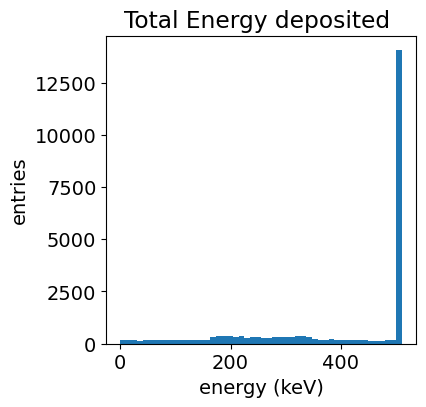

In [15]:
b, e = histoplot(dfx.etot, 'energy (keV)', "entries", bins=50, figsize=(6,6),
                title="Total Energy deposited ")

In [26]:
print(f" Fraction of events in peak ={b[-1]/np.sum(b)}")

 Fraction of events in peak =0.5546467520151731


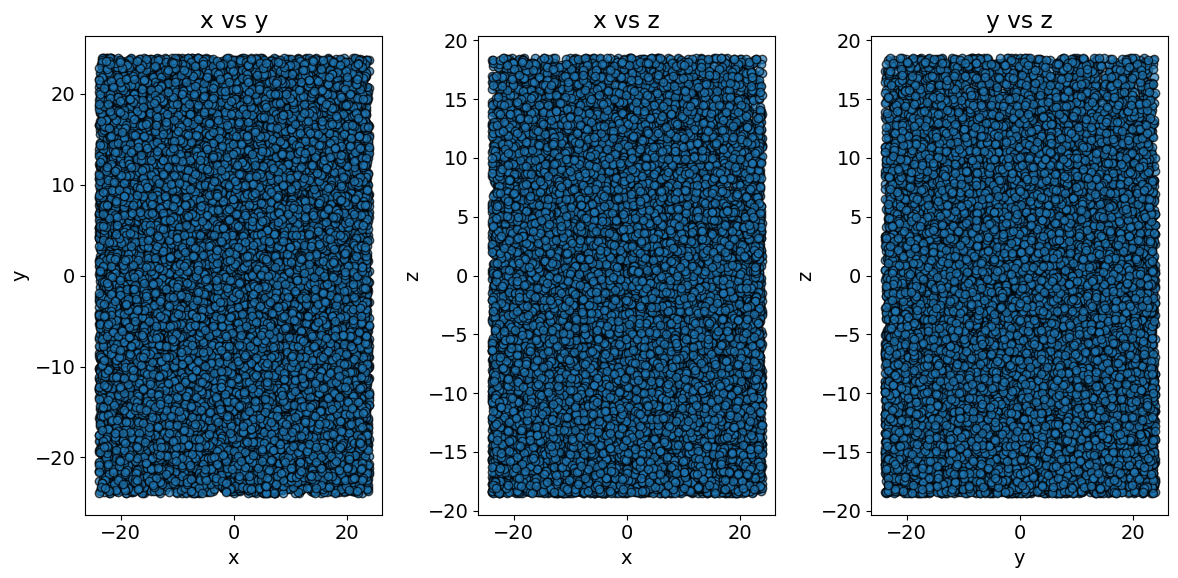

In [16]:
scatter_xyz(dfx.x,dfx.y,dfx.z, figsize=(12, 6))

In [17]:
print(f" mean of x : {(np.mean(dfx.x.values)):.2f}")
print(f" mean of y : {np.mean(dfx.y.values):.2f}")
print(f" mean of z : {np.mean(dfx.z.values):.2f}")

 mean of x : 0.21
 mean of y : -0.11
 mean of z : -3.04


### Cut in energy

In [27]:
ec = 0.98 *ge*1000 # in keV
print(f"cutoff energy = {ec:.2f}")
dfe = dfx[dfx.etot>ec]

cutoff energy = 500.78


In [28]:
x_e = event_size(dfe)/nn
print(f"fraction of events with e > {ec:.1f} keV = {x_e}")

fraction of events with e > 500.8 keV = 0.34055


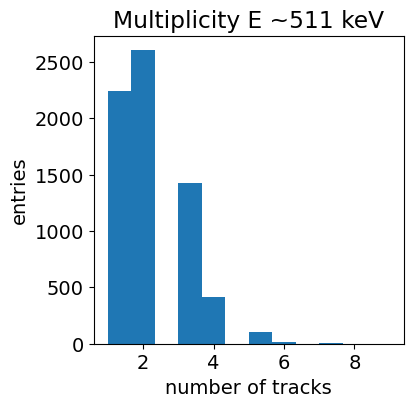

In [29]:
b, e = histoplot(event_mult(dfe), 'number of tracks', "entries", bins=12, figsize=(6,6),
                title="Multiplicity E ~511 keV")

### two cluster data frame (2cdf)

In [30]:
df2c = twocluster_df(dfe).drop('index', axis=1)
df2c.head(10)

,event,etot,ntrk,t1,x1,y1,z1,e1,t2,x2,y2,z2,e2
0,180000,511.0,2,26.5,8.0,-22.1,-10.5,9.1,101.8,11.1,-19.2,11.6,501.9
1,180001,511.0,2,84.3,23.6,-8.2,6.8,273.5,104.1,18.2,-10.3,5.9,237.5
2,180002,511.0,2,27.4,-17.6,-8.7,-10.3,289.5,46.8,-16.5,-14.1,-12.1,221.5
3,180003,511.0,2,65.0,-10.3,6.3,1.0,335.7,65.4,-10.3,6.3,0.9,175.3
4,180004,511.0,2,9.2,-5.9,-11.2,-15.8,263.2,22.4,-8.7,-14.0,-16.0,247.8
5,180005,511.0,2,6.3,5.3,4.5,-16.6,140.3,26.8,9.4,6.9,-12.8,370.7
6,180006,511.0,2,29.5,16.1,23.0,-9.6,98.8,72.1,17.7,14.8,0.1,412.2
7,180009,511.0,1,30.0,18.6,-23.8,-9.5,511.0,30.0,18.6,-23.8,-9.5,511.0
8,180012,511.0,2,56.7,18.1,-1.6,-1.5,296.9,61.8,16.6,-1.4,-2.1,214.1
9,180013,511.0,2,47.3,5.3,13.4,-4.3,301.4,68.5,8.5,8.6,-7.1,209.6


In [31]:
dfpe = df2c[df2c.ntrk==1]
dfco = df2c[df2c.ntrk>1]
print(f"Fraction of photoelectric events  = {event_size(dfpe)/event_size(df2c)}, of compton = {event_size(dfco)/event_size(df2c)}")
print(f"wrt total interactions  = {event_size(dfpe)/nn}, compton = {event_size(dfco)/nn}")

Fraction of photoelectric events  = 0.32961385993246217, of compton = 0.6703861400675378
wrt total interactions  = 0.11225, compton = 0.2283


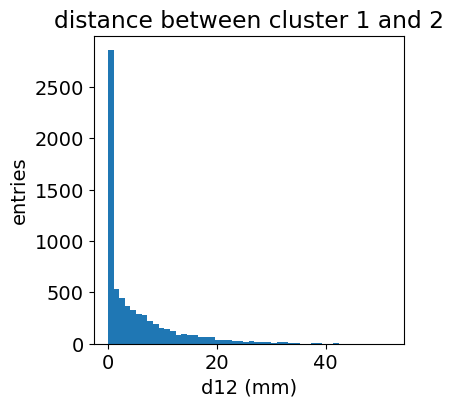

In [32]:
b, e = histoplot(d12(df2c), 'd12 (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between cluster 1 and 2")

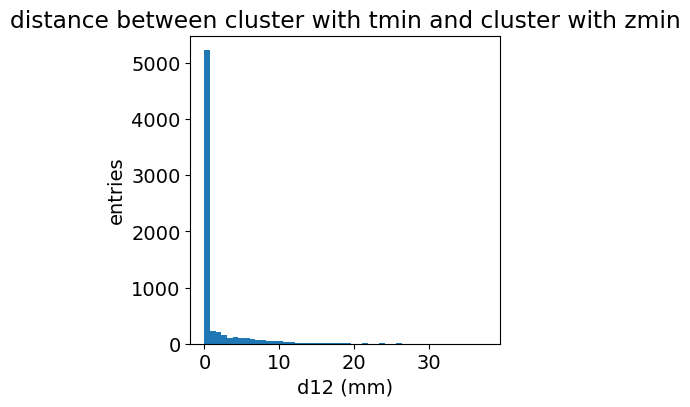

In [33]:
b, e = histoplot(dtz(df2c), 'd12 (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between cluster with tmin and cluster with zmin")

### Z asigment
- The plot above shows that most of the time the assigment of tmin to zmin works well, and results in zero error, with a small tail, which extends up to 5 mm.

## Read sensor data

In [34]:
dfgi = pd.read_csv(f"{g4dir}/{fid}", header=0).sort_values(by='event')
dfgi.head(10)

,event,sensor_id,amplitude
0,180000,31,152
34,180000,11,147
35,180000,16,132
36,180000,0,136
37,180000,1,148
38,180000,18,144
39,180000,35,156
40,180000,55,136
41,180000,4,133
42,180000,8,117


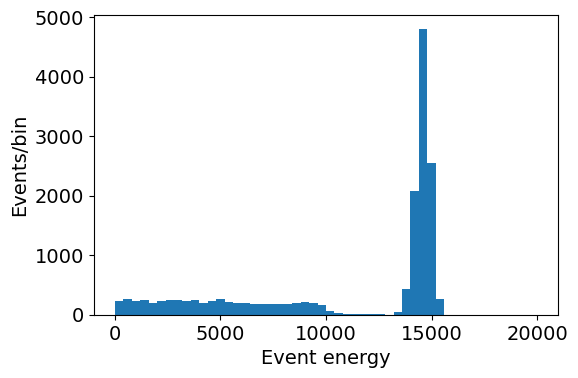

In [37]:
b, e = plot_amplitude(dfgi, num_bins = 50, xmin=0, xmax=2e+4,figsize=(6, 4), title="")

### Select events that pass the cuts of gamma DF (df2c)

In [38]:
sel_gi = df2c.event.values

In [39]:
# Filter the DataFrame using .isin() method
dfi = dfgi[dfgi['event'].isin(sel_gi)]
event_size(dfi)/event_size(dfgi)

0.4360435339308579

In [40]:
event_size(dfi)/event_size(df2c)

1.0

### Sensor positions

In [41]:
dfs = pd.read_csv(f"{g4dir}/{fsp}", header=0)
dfs.head(10)

,sensor_id,sensor_x,sensor_y,sensor_z
0,0,-21,-21,19.1
1,1,-21,-15,19.1
2,2,-21,-9,19.1
3,3,-21,-3,19.1
4,4,-21,3,19.1
5,5,-21,9,19.1
6,6,-21,15,19.1
7,7,-21,21,19.1
8,8,-15,-21,19.1
9,9,-15,-15,19.1


In [42]:
x_spatial = dfs.sensor_x.values
y_spatial = dfs.sensor_y.values

### Plot a few images

In [43]:
evt_indx = 10
event = sel_gi[evt_indx]

In [44]:
meta = df2c.iloc[evt_indx]
image = select_image_from_df(dfi,sel_gi[evt_indx])
print(f"Select event index = {evt_indx}, event = {int(meta.event)} (={sel_gi[evt_indx]})")

Select event index = 10, event = 180014 (=180014)


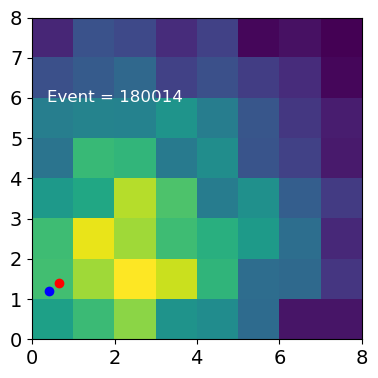

In [45]:
plot_image(image, meta, x_spatial, y_spatial, figsize=(4, 4), debug=False)

Select event index = 200, event = 180564 (=180564)


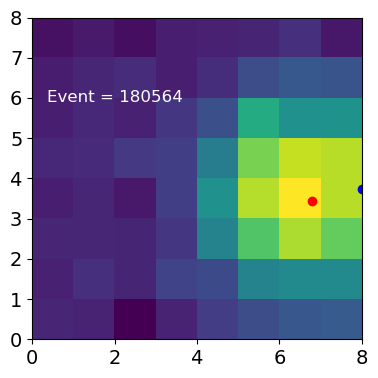

In [47]:
evt_indx = 200
event = sel_gi[evt_indx]
meta = df2c.iloc[evt_indx]
image = select_image_from_df(dfi,sel_gi[evt_indx])
print(f"Select event index = {evt_indx}, event = {int(meta.event)} (={sel_gi[evt_indx]})")
plot_image(image, meta, x_spatial, y_spatial, figsize=(4, 4), debug=False)